### [예제 4.1] 필터 기반 피처 선택법

In [1]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

X, y = load_digits(return_X_y=True, as_frame=True)
print('X의 크기:', X.shape)

X의 크기: (1797, 64)


In [2]:
myfilter = SelectKBest(chi2, k=20)
myfilter.fit(X, y)

cols = myfilter.get_support(indices=True)
X_new = X.iloc[:, cols]
print('필터링을 수행한 후 X의 크기:', X_new.shape)

필터링을 수행한 후 X의 크기: (1797, 20)


### 4.2.2 라쏘 모델 구현

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
%matplotlib inline

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
y = y - y.mean()

In [4]:
def soft_threshold(rho, alpha):
    if rho < -alpha:
        return rho + alpha
    elif rho > alpha:
        return rho - alpha
    return 0
    
def coordinate_descent_lasso(X, y, alpha=.01, num_iters=100):
    n,p = X.shape
    w = np.ones((p, ))
    z = np.zeros((p, ))

    for j in range(p):
        X_j = X[:, j].reshape(-1, 1)
        z[j] = np.inner(X[:, j], X[:, j])/n

    for i in range(num_iters): 
        for j in range(p):
            rho = np.inner(X[:, j], y - np.matmul(X, w) + w[j] * X[:, j]) / n
            w[j] = 1 / z[j] * soft_threshold(rho, alpha)

    return w.flatten()

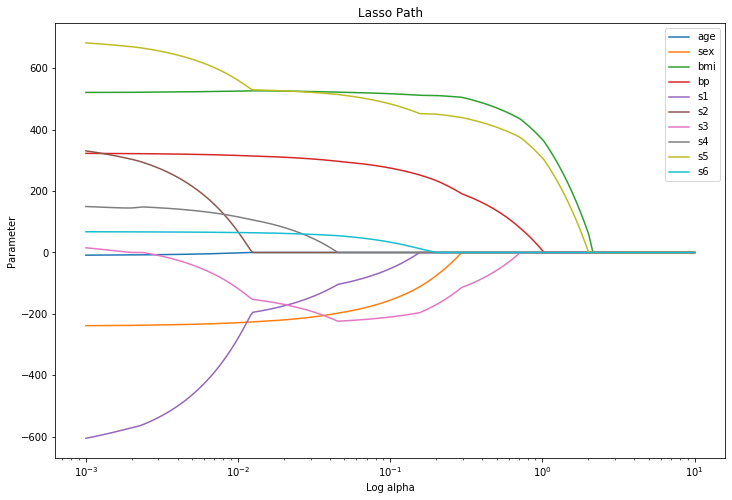

In [5]:
ws = []
alphas = np.logspace(-3, 1, 300)

for alpha in alphas:
    w = coordinate_descent_lasso(X, y, alpha=alpha, num_iters=100)
    ws.append(w)

w_lasso = np.stack(ws).T

plt.figure(figsize=(12, 8))
for i in range(w_lasso.shape[0]):
    plt.plot(alphas, w_lasso[i], label=diabetes.feature_names[i])

plt.xscale('log')
plt.xlabel('Log alpha')
plt.ylabel('Parameter')
plt.title('Lasso Path')
plt.legend()

### [예제 4.2] Lasso 클래스 사용하기

In [6]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.33, 
                                                    random_state=1234)

X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
221,-0.045472,-0.044642,-0.038540,-0.026328,-0.015328,0.000878,-0.032356,-0.002592,0.001144,-0.038357
176,0.045341,0.050680,0.019662,0.039087,0.020446,0.025930,0.008142,-0.002592,-0.003304,0.019633
227,0.067136,0.050680,-0.029918,0.057449,-0.000193,-0.015719,0.074412,-0.050564,-0.038459,0.007207
434,0.016281,-0.044642,0.001339,0.008101,0.005311,0.010899,0.030232,-0.039493,-0.045421,0.032059
110,0.041708,0.050680,-0.032073,-0.022885,-0.049727,-0.040144,0.030232,-0.039493,-0.126097,0.015491


In [7]:
scaler = StandardScaler()
reg = Lasso(alpha=10, random_state=1234)

pipe = Pipeline(steps=[("scaler", scaler), ("reg", reg)])
pipe = pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print(f'학습 데이터셋 MAE:{np.abs(y_train_pred - y_train).mean(): .3f}')
print(f'테스트 데이터셋 MAE:{np.abs(y_pred - y_test).mean(): .3f}')

학습 데이터셋 MAE: 47.475
테스트 데이터셋 MAE: 46.139


In [8]:
print('추정 파라미터의 값:\n', reg.coef_)

추정 파라미터의 값:
 [ 0.         -0.         22.14741042  7.25438995 -0.         -0.
 -4.43633143  0.         18.8046418   0.        ]


In [9]:
print('re.coef_[0]의 클래스:', type(reg.coef_[0]))
print('re.coef_[1]의 클래스:', type(reg.coef_[1]))
print('re.coef_[0]과 0의 동일 여부:', reg.coef_[0] == 0)
print('re.coef_[1]과 0의 동일 여부:', reg.coef_[1] == 0)

re.coef_[0]의 클래스: <class 'numpy.float64'>
re.coef_[1]의 클래스: <class 'numpy.float64'>
re.coef_[0]과 0의 동일 여부: True
re.coef_[1]과 0의 동일 여부: True


### [예제 4.3] AIC, BIC, 교차검증법을 이용한 라쏘 모델의 모델 선택법

In [10]:
# Author: Olivier Grisel
#         Gael Varoquaux
#         Alexandre Gramfort
#         Guillaume Lemaitre
# License: BSD 3 clause

from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [11]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(1234)
X_random = pd.DataFrame(rng.randn(X.shape[0], 14), 
                        columns=[f"random_{i:02d}" for i in range(14)])
X = pd.concat([X, X_random], axis=1)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,random_04,random_05,random_06,random_07,random_08,random_09,random_10,random_11,random_12,random_13
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,...,-0.720589,0.887163,0.859588,-0.636524,0.015696,-2.242685,1.150036,0.991946,0.953324,-2.021255
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,...,1.321158,-1.546906,-0.202646,-0.655969,0.193421,0.553439,1.318152,-0.469305,0.675554,-1.817027
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,...,1.047579,1.045938,0.863717,-0.122092,0.124713,-0.322795,0.841675,2.390961,0.076200,-0.566446
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,...,-0.136795,0.018289,0.755414,0.215269,0.841009,-1.445810,-1.401973,-0.100918,-0.548242,-0.144620
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,...,-0.974236,-0.070345,0.307969,-0.208499,1.033801,-2.400454,2.030604,-1.142631,0.211883,0.704721


In [12]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
%matplotlib inline

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), 
                              LassoLarsIC(criterion="aic", 
                                          normalize=False)).fit(X, y)
fit_time = time.time() - start_time

In [13]:
results = pd.DataFrame({
    "alphas": lasso_lars_ic[-1].alphas_, 
    "AIC criterion": lasso_lars_ic[-1].criterion_
}).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_
print(f'alpha_aic:{alpha_aic: .3f}')

alpha_aic: 1.981


In [14]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_
print(f'alpha_bic:{alpha_bic: .3f}')

alpha_bic: 4.516


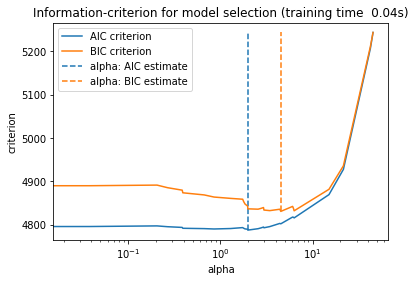

In [15]:
ax = results.plot()
ax.vlines(alpha_aic, 
          results["AIC criterion"].min(), 
          results["AIC criterion"].max(), 
          label="alpha: AIC estimate", 
          linestyles="--", 
          color="tab:blue")
ax.vlines(alpha_bic, 
          results["BIC criterion"].min(), 
          results["BIC criterion"].max(), 
          label="alpha: BIC estimate", 
          linestyle="--", 
          color="tab:orange")
ax.set_xlabel('alpha')
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(f"Information-criterion for model selection (training time {fit_time: .2f}s)")

In [16]:
from sklearn.linear_model import LassoCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

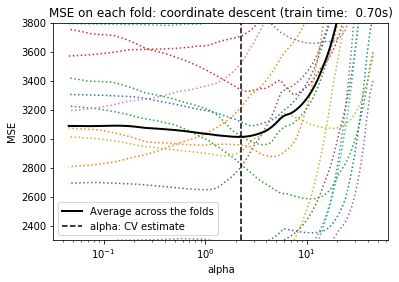

In [17]:
lasso = model[-1]
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(lasso.alphas_, 
         lasso.mse_path_.mean(axis=-1), 
         color="black", 
         label="Average across the folds", 
         linewidth=2)
plt.axvline(lasso.alpha_, 
            linestyle="--", 
            color="black", 
            label="alpha: CV estimate")

plt.ylim(2300, 3800)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.legend()
_ = plt.title(f"MSE on each fold: coordinate descent (train time: {fit_time: .2f}s)")

## 04 되새김 문제

### [되새김 문제 4.1] 스케일링과 LassoCV 파이프라인

#### 문제

In [18]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=1234)

#### 풀이

In [19]:
lassoCV = LassoCV(alphas=[0.01, 0.1, 1, 10, 100], cv=10)
reg = make_pipeline(StandardScaler(), lassoCV).fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('최적의 alpha:', lassoCV.alpha_)
print(f'계수: {lassoCV.coef_}')
print(f'MAE:{(np.abs(y_pred - y_test)).mean(): .3f}')

최적의 alpha: 1.0
계수: [ -0.         -11.51765404  23.99105458  14.40703304  -5.33719989
  -0.          -9.73608914   2.29161593  23.67465157   3.04274953]
MAE: 42.992


### [되새김 문제 4.2] 불필요한 피처가 많은 상황에서 선형 모델 비교하기

#### 문제

In [20]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

X, y = make_regression(n_samples=300, 
                       n_features=400, 
                       n_informative=50, 
                       n_targets=1, 
                       bias=0.0, 
                       noise=10.0, 
                       random_state=1234)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=1234)

#### 풀이

In [21]:
reg1 = LinearRegression()
reg1 = reg1.fit(X_train, y_train)
y_train_pred = reg1.predict(X_train)
print(f'학습 데이터셋 기준 OLS 모델의 MSE:{((y_train - y_train_pred)**2).mean(): .2f}')

y_test_pred = reg1.predict(X_test)
print(f'테스트 데이터셋 기준 OLS 모델의 MSE:{((y_test - y_test_pred)**2).mean(): .2f}')

학습 데이터셋 기준 OLS 모델의 MSE: 0.00
테스트 데이터셋 기준 OLS 모델의 MSE: 66235.35


In [22]:
reg2 = Lasso()
reg2 = reg2.fit(X_train, y_train)
y_train_pred = reg2.predict(X_train)
print(f'학습 데이터셋 기준 LASSO 모델의 MSE:{((y_train - y_train_pred)**2).mean(): .2f}')

y_test_pred = reg2.predict(X_test)
print(f'테스트 데이터셋 기준 LASSO 모델의 MSE:{((y_test - y_test_pred)**2).mean(): .2f}')

학습 데이터셋 기준 LASSO 모델의 MSE: 130.41
테스트 데이터셋 기준 LASSO 모델의 MSE: 457.40
